In [0]:
# Loading clinicaltrial_2021 data into DataFrame
Clinicaltrial_2021_df = spark.read.format('csv').option('header', 'true').load('/FileStore/tables/clinicaltrial_2021.csv')
Clinicaltrial_2021_df.createOrReplaceTempView('clinicaltrial_2021')
 
# Load pharma data into DataFrame
pharma_df = spark.read.format('csv').option('header', 'true').load('/FileStore/tables/pharma.csv')
pharma_df.createOrReplaceTempView('pharma')

In [0]:
Clinicaltrial_2021_df.printSchema()


root
 |-- Id: string (nullable = true)
 |-- Sponsor: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Start: string (nullable = true)
 |-- Completion: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Submission: string (nullable = true)
 |-- Conditions: string (nullable = true)
 |-- Interventions: string (nullable = true)



In [0]:
Clinicaltrial_2021_df.show(4)


+-----------+--------------------+----------+--------+----------+--------------+----------+--------------------+-------------+
|         Id|             Sponsor|    Status|   Start|Completion|          Type|Submission|          Conditions|Interventions|
+-----------+--------------------+----------+--------+----------+--------------+----------+--------------------+-------------+
|NCT02758028|The University of...|Recruiting|Aug 2005|  Nov 2021|Interventional|  Apr 2016|                null|         null|
|NCT02751957|     Duke University| Completed|Jul 2016|  Jul 2020|Interventional|  Apr 2016|Autistic Disorder...|         null|
|NCT02758483|Universidade Fede...| Completed|Mar 2017|  Jan 2018|Interventional|  Apr 2016|   Diabetes Mellitus|         null|
|NCT02759848|Istanbul Medeniye...| Completed|Jan 2012|  Dec 2014| Observational|  May 2016|Tuberculosis,Lung...|         null|
+-----------+--------------------+----------+--------+----------+--------------+----------+--------------------

In [0]:
#Q1 Display number of distinct studies in the dataset.

# Load the dataset as a DataFrame
Clinicaltrial_2021_df = spark.read.option("header", "true").option("delimiter", "|").csv("/FileStore/tables/clinicaltrial_2021.csv")

In [0]:
# Rename the columns
Clinicaltrial_2021_df = Clinicaltrial_2021_df.withColumnRenamed("id","Id") \
       .withColumnRenamed("sponsor","Sponsor") \
       .withColumnRenamed("status","Status") \
       .withColumnRenamed("start_date","Start") \
       .withColumnRenamed("completion_date","Completion") \
       .withColumnRenamed("type","Type") \
       .withColumnRenamed("submission_date","Submission") \
       .withColumnRenamed("conditions","Conditions") \
       .withColumnRenamed("interventions","Interventions")

In [0]:
Clinicaltrial_2021_df = Clinicaltrial_2021_df.dropna(how="all", thresh=None, subset=None)


In [0]:
#Q1  Display number of distinct studies in the dataset.

# Get the distinct studies by the Id column and count them
count_distinct_studies_df = Clinicaltrial_2021_df.select("Id").distinct().count()

print("Q1 Display number of distinct studies in the dataset.")
# Print the result
print(f"Number of distinct studies: {count_distinct_studies_df}")

Q1 Display number of distinct studies in the dataset.
Number of distinct studies: 387261


In [0]:
#Q2 Types of studies in the dataset along with the frequencies of each type.
 
from pyspark.sql.functions import desc
 
type_studies = Clinicaltrial_2021_df.groupBy('Type').count().orderBy(desc('count'))

 print("Q2 Types of studies in the dataset along with the frequencies of each type.")

type_studies.show()

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



In [0]:
# Q3 Top 5 conditions (from Conditions) with their frequencies.


# Import the necessary functions
from pyspark.sql.functions import explode, split
 
# Find the top 5 conditions and their frequencies
Top_conditions_df = Clinicaltrial_2021_df.select(explode(split('Conditions', ';')).alias('Condition'))
Top_conditions_df = Top_conditions_df.groupBy('Condition').count()
Top_conditions_df = Top_conditions_df.sort('count', ascending=False)
Top_conditions_df = Top_conditions_df.limit(5)

In [0]:
# Print the results
print("Q3 Top 5 conditions (from Conditions) with their frequencies.")

Top_conditions_df.show()


Q3 Top 5 conditions (from Conditions) with their frequencies.
+-------------------+-----+
|          Condition|count|
+-------------------+-----+
|  Diabetes Mellitus| 7460|
|   Breast Neoplasms| 6054|
|          Carcinoma| 3788|
|Prostatic Neoplasms| 3700|
|           COVID-19| 3118|
+-------------------+-----+



In [0]:
#Q4 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored.

# Joining the 2 Tables clinicaltrial_2021 and pharma dataframes
joined_df = Clinicaltrial_2021_df.join(pharma_df, Clinicaltrial_2021_df.Sponsor == pharma_df.Parent_Company, how='left')


# Filter out the pharmaceutical companies
non_pharma_df = joined_df.filter(pharma_df.Parent_Company.isNull())
from pyspark.sql.functions import countDistinct
 

In [0]:

# Group by Sponsor and count the number of trials
result_df = non_pharma_df.groupBy('Sponsor').agg(countDistinct('Id').alias('number_trials'))
 
print("Q4 10 most common sponsors that are not pharmaceutical companies with their frequency.")

# Sort by the number of trials in descending order and take the top 10
Top_sponsors_df=result_df.orderBy(desc('number_trials')).limit(10).show()

Q4 10 most common sponsors that are not pharmaceutical companies with their frequency.
+--------------------+-------------+
|             Sponsor|number_trials|
+--------------------+-------------+
|National Cancer I...|         3218|
|M.D. Anderson Can...|         2414|
|Assistance Publiq...|         2369|
|         Mayo Clinic|         2300|
|Merck Sharp & Doh...|         2243|
|   Assiut University|         2154|
|Novartis Pharmace...|         2088|
|Massachusetts Gen...|         1971|
|    Cairo University|         1928|
|   Hoffmann-La Roche|         1828|
+--------------------+-------------+



In [0]:
#Q5 Number of completed studies each month in 2021

from pyspark.sql.functions import *
 
# Number of completed studies in each month
final_df = Clinicaltrial_2021_df. \
    filter("Status == 'Completed'"). \
    filter('Completion IS NOT NULL'). \
    groupby(date_format(to_date('Completion','MMM yyyy'),"MM").alias("MONTH")). \
    count().\
    sort('MONTH')

In [0]:
final_df.show()


+-----+-----+
|MONTH|count|
+-----+-----+
|   01|15823|
|   02|13492|
|   03|17465|
|   04|15103|
|   05|15943|
|   06|19579|
|   07|16580|
|   08|15933|
|   09|16436|
|   10|15119|
|   11|13939|
|   12|27944|
+-----+-----+



<Figure size 720x432 with 0 Axes>

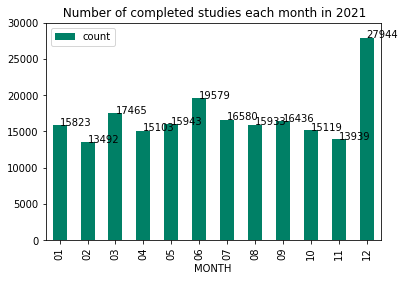

In [0]:
import matplotlib.pyplot as plt
plot_completed=final_df.toPandas()
#ax = pdf.plot(kind='bar',  title='Monthly Completed', rot=0)
 
plt.figure(figsize=(10,6))
#fig, ax = plt.bar(monthly_completed['comp_month'], monthly_completed['CNT'])
ax = plot_completed.plot(kind='bar',x='MONTH',y='count',colormap='summer')
ax.set_ylim(0, 30000)
plt.title(' Number of completed studies each month in 2021')
for i, label in enumerate(list(plot_completed.index)):
    cnt = plot_completed.loc[label]['count']
    ax.annotate(str(cnt), (i, cnt + 0.2))
plt.show()